In [1]:
%%html
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [2]:
import hax
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from matplotlib.colors import LogNorm
from collections import defaultdict
from array import array
import pylab
from hax import cuts
import os

In [3]:
def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

# Using Machine Learning for single scatter cut

## Motivation:
* Create and tune learner to use in  a single scatter s2 cut. Analyze how well such methods can be applied to the cut, in comparison to others.


## Methods:

### Previous note
* Make sure simulation agrees with calibration data

### This note
* From full chain simulation, know whether an event is MS or SS
* Decide on which spaces are best to train a machine learner in for this cut
* Train and optimize learner, export

### To Do
* Apply it in a two step cut: Learner -> GoF cut
* Test the cut's efficiencies


## Importing data

### sim - full chain ambe data
### ambe - SR1 ambe calibration data
### rn - SR1 radon calibration data

#### Features
 * area
 * width
 * goodness of top pattern fit
 * delay from main s2
 * delay from main s1
 * z
 * r
 
#### Train on
* S2 and largest other s2
 * area
 * width
 * delay from main s2 (largest other)
 * z (s2)
 * x-y distance between the two

In [4]:
sim = pd.read_pickle('full_chain_ambe_faxed.pkl')

In [5]:
sim = pd.read_pickle('full_chain_ambe_faxed.pkl')
sim = sim[sim.s2 > 200]
ambe = pd.read_pickle('ambe_calib.pkl')
rn = pd.read_pickle('rn_calib.pkl')

import funcs
from funcs import prepare_data
from funcs import chosen_cuts


ambe = chosen_cuts(ambe)
rn = chosen_cuts(rn)
sim = chosen_cuts(sim)

ml_sim = prepare_data(sim)
ml_ambe = prepare_data(ambe)
ml_rn = prepare_data(rn)

## Fitting the Random Forests

### Random Forest

In [6]:
toPredict = ml_ambe
toTrain = ml_sim

In [7]:
# import sklearn

from sklearn.cross_validation import train_test_split
X, y = toTrain.iloc[:,1:].values, toTrain.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

/home/shawaf/anaconda3/envs/pax/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, 
                             criterion='entropy',
                             random_state=0,
                             max_depth=5,
                             min_samples_split = 50,
                             n_jobs=-1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [9]:
%%capture
feat_labels = toTrain.columns[1:]

importances = rfc.feature_importances_
indicies = np.argsort(importances)[::-1]
for f in  range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                           feat_labels[indicies[f]],
                           importances[indicies[f]]))

In [10]:
print("RandomForest test score is:", rfc.score(X_test, y_test))

RandomForest test score is: 0.927380125087


## How important each feature is in each classifier

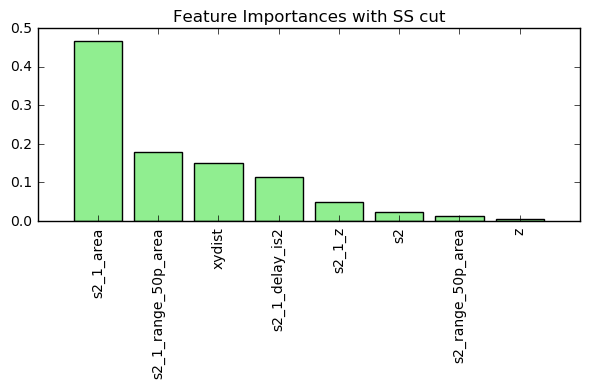

In [11]:
plt.title('Feature Importances with SS cut')
plt.bar(range(X_train.shape[1]),
       importances[indicies],
       color='lightgreen',
       align = 'center')
plt.xticks(range(X_train.shape[1]),
          feat_labels[indicies], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [12]:
predict_test = rfc.predict(X_test)

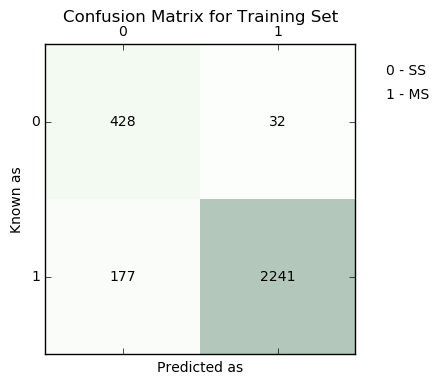

In [13]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=predict_test)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Greens, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.title('Confusion Matrix for Training Set')

plt.xlabel('Predicted as')
plt.ylabel('Known as')

plt.text(x=1.7, y=-0.3, s='0 - SS')
plt.text(x=1.7, y=-0.15, s='1 - MS')
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

# Predicting AmBe data

In [14]:
predict_results = rfc.predict(np.array(toPredict)[:,1:])

In [15]:
predictions = np.unique(predict_results, return_counts=True)
sm = predictions[1][0] + predictions[1][1]
print("RandomForest applied to ambe data. \n Proportion classified as AmBe/MS: %s \n Proportion classified as Rn/SS: %s " % (str(predictions[1][0]/sm),str(predictions[1][1]/sm)))

RandomForest applied to ambe data. 
 Proportion classified as AmBe/MS: 0.203923627059 
 Proportion classified as Rn/SS: 0.796076372941 


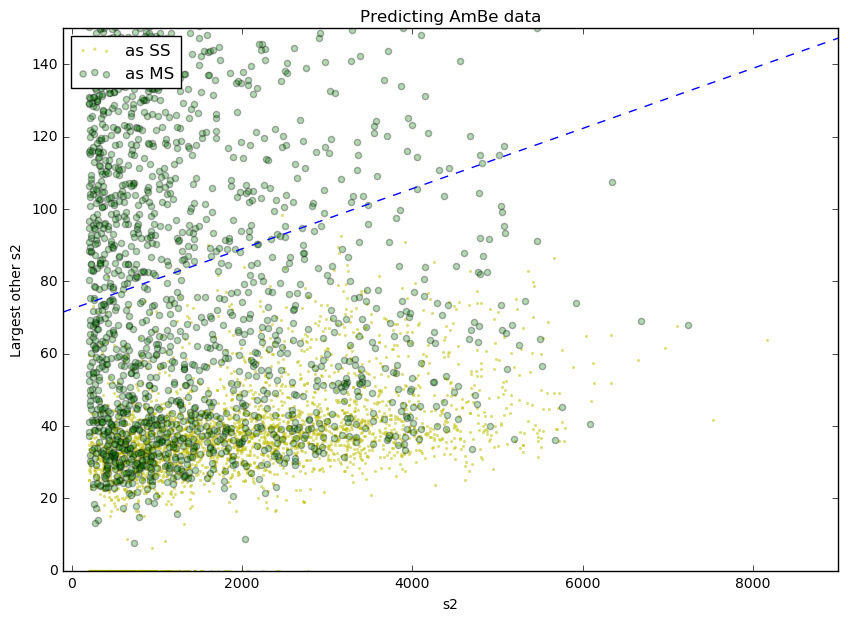

Number of ambe data predicted as MS within SS cut: 996
Number of ambe data predicted as SS outside SS cut: 4


In [16]:
toPredict['predicted_class'] = predict_results
plt.figure(figsize=(10,7))

plt.scatter(toPredict[toPredict['predicted_class'] == 1]["s2"], toPredict[toPredict['predicted_class'] == 1]["s2_1_area"],
            c='y', marker = '.', lw=0 , alpha = .5, label = "as SS")
plt.scatter(toPredict[toPredict['predicted_class'] == 2]["s2"], toPredict[toPredict['predicted_class'] == 2]["s2_1_area"],
            c='g', marker = 'o', alpha = .3,label = "as MS")


x = np.linspace(-100,10000,10000)
plt.plot(x,ses2_size_cut_ori(x),linestyle='--')

plt.xlim(-100,9000)
plt.ylim(0,150)

plt.title("Predicting AmBe data")
plt.xlabel("s2")
plt.ylabel("Largest other s2")

plt.legend(loc='upper left')
plt.show()

r = toPredict[(toPredict['predicted_class'] == 2) & (toPredict['s2_1_area'] <= ses2_size_cut_ori(toPredict['s2']))]['class'].count()
q = toPredict[(toPredict['predicted_class'] == 1) & (toPredict['s2_1_area'] >= ses2_size_cut_ori(toPredict['s2']))]['class'].count()

print('Number of ambe data predicted as MS within SS cut:',r)
print('Number of ambe data predicted as SS outside SS cut:',q)

In [17]:
y_pred_proba = rfc.predict_proba(np.array(toPredict.drop("predicted_class",1))[:,1:])
nr_pred_proba = y_pred_proba

## Truncated at ends b/c scaling, amount of ambiguity:

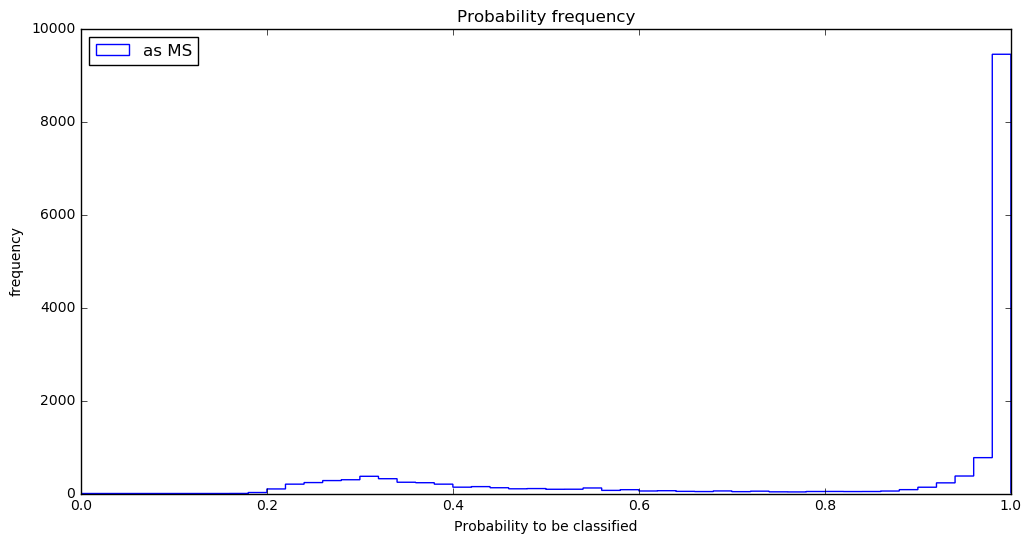

In [18]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.hist(y_pred_proba.T[1], bins = 50,histtype = 'step', linestyle = 'solid',range = (0,1),label = 'as MS')

plt.legend(loc='upper left')
plt.xlabel('Probability to be classified')
plt.ylabel('frequency')
plt.title('Probability frequency')
plt.show()

In [19]:
u = y_pred_proba.T[1]
v = ((u>.2)&(u<.8)).sum()
print("Amount of events with probabilities to be classified between 20% and 80%:", v)

Amount of events with probabilities to be classified between 20% and 80%: 3997


In [20]:
ambe['predicted_class'] = toPredict['predicted_class']

# Predicting Rn data

In [21]:
toPredict = ml_rn

In [22]:
predict_results = rfc.predict(np.array(toPredict)[:,1:])

In [23]:
predictions = np.unique(predict_results, return_counts=True)
sm = predictions[1][0] + predictions[1][1]
print("RandomForest applied to ambe data. \n Proportion classified as AmBe/MS: %s \n Proportion classified as Rn/SS: %s " % (str(predictions[1][0]/sm),str(predictions[1][1]/sm)))

RandomForest applied to ambe data. 
 Proportion classified as AmBe/MS: 0.768481375358 
 Proportion classified as Rn/SS: 0.231518624642 


In [24]:
predictions

(array([1, 2]), array([1341,  404]))

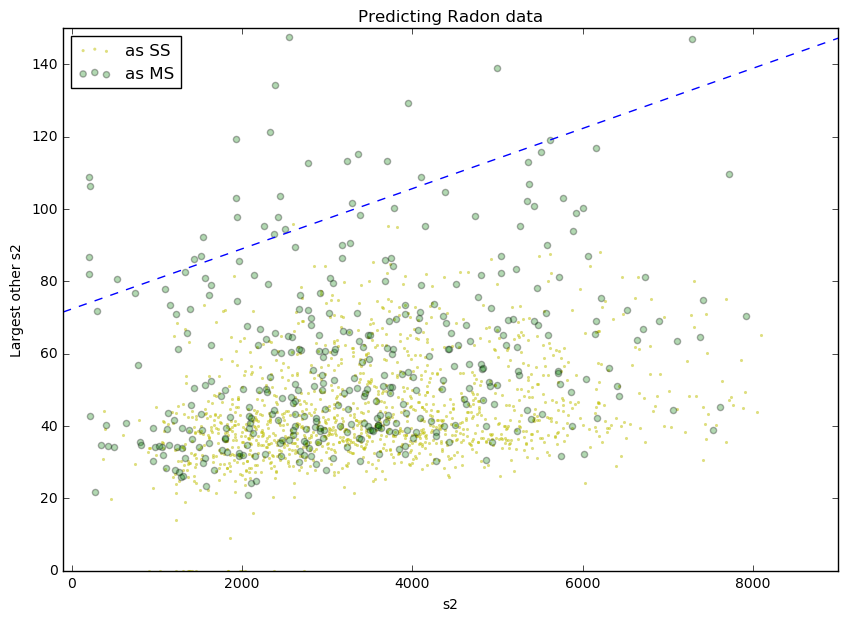

Number of ambe data predicted as MS within SS cut: 345
Number of ambe data predicted as SS outside SS cut: 1


In [25]:
toPredict['predicted_class'] = predict_results
plt.figure(figsize=(10,7))

plt.scatter(toPredict[toPredict['predicted_class'] == 1]["s2"], toPredict[toPredict['predicted_class'] == 1]["s2_1_area"],
            c='y', marker = '.', lw=0 , alpha = .5, label = "as SS")
plt.scatter(toPredict[toPredict['predicted_class'] == 2]["s2"], toPredict[toPredict['predicted_class'] == 2]["s2_1_area"],
            c='g', marker = 'o', alpha = .3,label = "as MS")


x = np.linspace(-100,10000,10000)
plt.plot(x,ses2_size_cut_ori(x),linestyle='--')

plt.xlim(-100,9000)
plt.ylim(0,150)

plt.title("Predicting Radon data")
plt.xlabel("s2")
plt.ylabel("Largest other s2")

plt.legend(loc='upper left')
plt.show()

r = toPredict[(toPredict['predicted_class'] == 2) & (toPredict['s2_1_area'] <= ses2_size_cut_ori(toPredict['s2']))]['class'].count()
q = toPredict[(toPredict['predicted_class'] == 1) & (toPredict['s2_1_area'] >= ses2_size_cut_ori(toPredict['s2']))]['class'].count()

print('Number of ambe data predicted as MS within SS cut:',r)
print('Number of ambe data predicted as SS outside SS cut:',q)

In [26]:
y_pred_proba = rfc.predict_proba(np.array(toPredict.drop("predicted_class",1))[:,1:])
rn_pred_proba = y_pred_proba

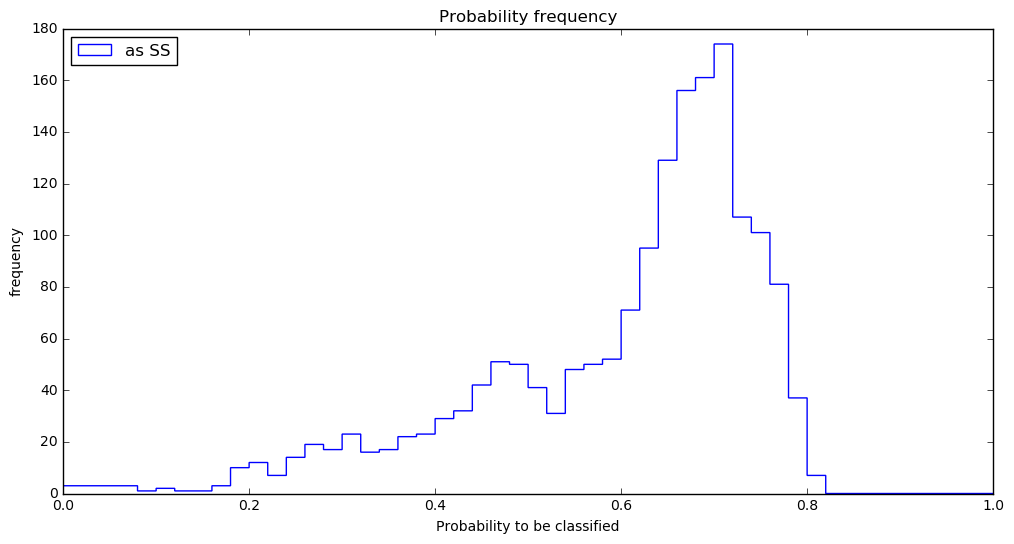

In [27]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(12)

plt.hist(y_pred_proba.T[0], bins = 50,histtype = 'step', linestyle = 'solid',range = (0,1),label = 'as SS')

plt.legend(loc='upper left')
plt.xlabel('Probability to be classified')
plt.ylabel('frequency')
plt.title('Probability frequency')
plt.show()

In [28]:
u = y_pred_proba.T[1]
v = ((u>.2)&(u<.8)).sum()
print("Amount of events with probabilities to be classified between 20% and 80%:", v)

Amount of events with probabilities to be classified between 20% and 80%: 1708


In [29]:
rn['predicted_class'] = toPredict['predicted_class']

In [30]:
ambe_prob_ms = nr_pred_proba.T[1]
rn_prob_ms = rn_pred_proba.T[1]

In [31]:
ambe['prob_ss'] = nr_pred_proba.T[0]
rn['prob_ss'] = rn_pred_proba.T[0]

In [32]:
def eff(t):
    """ Determines the efficiencies from the probability histograms at a probability cutoff t """
    ambe_less_t = [i for i in ambe_prob_ms if i <= t]
    acc_t = 1 - len(ambe_less_t)/len(ambe_prob_ms)
    rn_greater_t = [i for i in rn_prob_ms if i > t]
    rej_t = 1 - len(rn_greater_t)/len(rn_prob_ms)
    return [rej_t, acc_t]

In [33]:
acc_rej = np.array([eff(i) for i in np.linspace(0,1,1000)])
# saving this curve based on trainer
# acc_rej.tofile('acc_rej_1.csv',sep=',',format='%10.5f')

In [34]:
acc_rej_1 = pd.read_csv('acc_rej_1.csv')

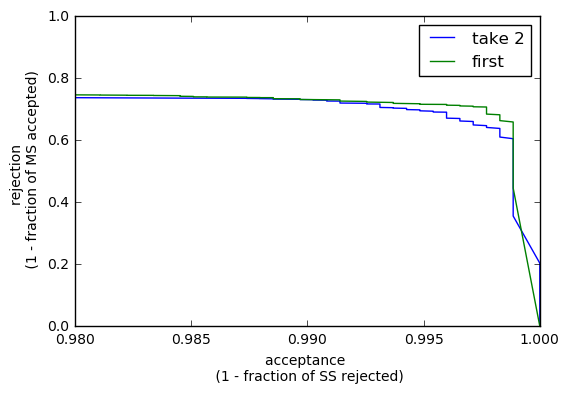

In [35]:
plt.plot(acc_rej.T[0], acc_rej.T[1], label='take 2')
plt.plot(acc_rej_1.acc, acc_rej_1.rej, label = 'first')
plt.xlabel('acceptance \n (1 - fraction of SS rejected)')
plt.ylabel('rejection \n (1 - fraction of MS accepted)')

plt.xlim(.98,1.0)
plt.legend()
plt.show()

In [36]:
def slp(i):
    """Calculates the approx. slope between the i and i + 1 entry of the plot above"""
    a_ = acc_rej[i + 1] - acc_rej[i]
    if a_[0] != 0.:
        return a_[1]/a_[0]
    else:
        return float('nan')

In [37]:
""" find index of entry at slope on this graph """
slope_to_find = -0.5
want_to_min = [slope_to_find - slp(i) for i in range(0,len(acc_rej) - 1)]

import math
ref = [value for value in want_to_min if not math.isnan(value)]
no_nan = [value for value in want_to_min if not math.isnan(value)]
no_nan = [abs(value) for value in no_nan]

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

want_to_min.index(find_nearest(ref, min(no_nan)))

352

## Acceptance

In [38]:
def acc_binned(df, bins, cutoff_prob = 0.2):
    """Designed to slice in a 2-d space, fit gauss to those slices, and return a binned dataframe"""
    bin_mids = []
    sigmas = []
    means = []

    for i in range(1, len(bins)):
        a = df.loc[(df['s2'] < bins[i]) & (df['s2'] > bins[i-1])]
        
        # mn is acceptance over this binned region
        if len(a.index) != 0:
            mn = len(a[a['prob_ss'] > cutoff_prob].index)/len(a.index)
        
        bm = np.mean(a['s2'])

        if (np.logical_not(np.isnan(mn))):
            means.append(mn)
            bin_mids.append(bm)

    return pd.DataFrame(np.array([bin_mids, means]).T, index = range(len(means)), columns = ['s2','acceptance'])

In [39]:
bins = np.linspace(200, 6000, 30)
rn_acc = acc_binned(rn, bins, cutoff_prob = 0.3)

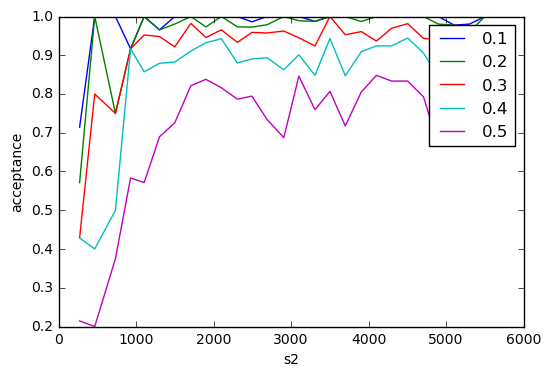

In [40]:
for prob in np.arange(0.1,0.6,0.1):
    rn_acc = acc_binned(rn, bins, cutoff_prob = prob)
    plt.plot(rn_acc['s2'], rn_acc['acceptance'], label = str(prob))
plt.legend()
plt.ylabel('acceptance')
plt.xlabel('s2')
plt.show()